<h1>This notebook keeps track of the progress made with data analysis for COSI and MEGAlib using python</h1>

<h5>For some reason I have to execute the first cell two times</h5>

In [370]:
import ROOT as M
import numpy as np
import scipy.optimize as op
from scipy.interpolate import RectBivariateSpline
import sys
import os
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.style.use('thomas')
import time
from astropy.time import Time
from astropy.stats import bayesian_blocks

from COSIpy_tools import * # specific routines for use with COSI and MEGAlib data

import warnings
warnings.filterwarnings('ignore')

from tqdm import tqdm_notebook as tqdm
from IPython.display import Image

import emcee
import corner

# Load MEGAlib into ROOT
M.gSystem.Load("$(MEGAlib)/lib/libMEGAlib.so")

# Initialize MEGAlib
G = M.MGlobal()
G.Initialize()

True

In [3]:
import importlib
%reload_ext autoreload
%autoreload 2
%aimport COSIpy_tools

<h3>Define values to read in, convert to numpy arrays >> COSIpy_tools.read_COSI_DataSet(dir)</h3>

<h3>As example, we read in the full flight data set between 506 and 516 keV, with Earth Horizon Cut (EHC), quality cuts (GTI/BTI), and Compton angle cuts (less than 60 deg) similar to how the response was created (later)</h3>

In [6]:
dir = '/Users/thomassiegert/data/COSI/FlightData_Processed_v4/CE0506-0516_GTI_EHQCSAcuts/'
COSI_Data_GTI = read_COSI_DataSet(dir)

Error in <TProtoClass::FindDataMember>: data member with index 0 is not found in class locale
Error in <CreateRealData>: Cannot find data member # 0 of class locale for parent MFile!
Error in <TProtoClass::FindDataMember>: data member with index 0 is not found in class locale
Error in <CreateRealData>: Cannot find data member # 0 of class locale for parent MFileEvents!
Error in <TProtoClass::FindDataMember>: data member with index 0 is not found in class locale
Error in <CreateRealData>: Cannot find data member # 0 of class locale for parent MFileEventsTra!


In [10]:
obs_days = len(COSI_Data_GTI)

<h3>Get hourly tags and binning >> COSIpy_tools.hourly_tags(COSI_Data) / COSIpy_tools.hourly_binning(COSI_Data)</h3>

In [11]:
tdx_GTI = np.array(hourly_tags(COSI_Data_GTI))
tdx_GTI = tdx_GTI.reshape(obs_days,24)

In [13]:
gti_data = hourly_binning(COSI_Data_GTI)

<h5>Check out observation pattern (exposure map) per hour averaged</h5>

Text(0, 0.5, 'Gal. Lat. [deg]')

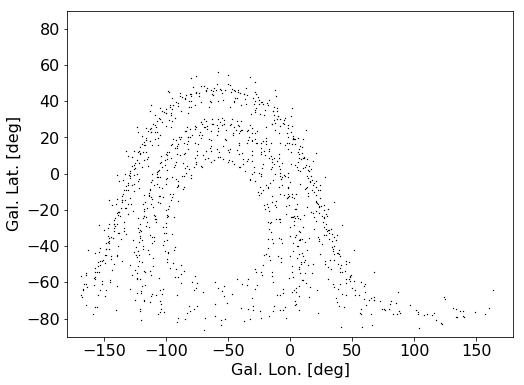

In [30]:
fig, ax = plt.subplots()
ax.plot(np.rad2deg(gti_data['GLons']),np.rad2deg(gti_data['GLats']),'d',markersize=0.5)
ax.set_xlim(-180,180)
ax.set_ylim(-90,90)
ax.set_xlabel('Gal. Lon. [deg]')
ax.set_ylabel('Gal. Lat. [deg]')

<h3>Now to bin the data in the same way as the response is created: <br>
    2D SKY (zenith/azimuth), 1D PHI (Compton angle), 2D CHI/PSI (other scattering angles) <br>
    [plus, 1D EIN (initial energy), 1D EOUT (measured energy), 1D DIST (lever arm), 2D SIGMA/TAU (recoil electron angles)] <br>
    We need a loop over all events in all days and hours to collect them in the right bins<br>
    >> COSIpy_tools.get_binned_data(COSI_Data,tdx,pp,bb,ll,dpp,dbb,dll)<br>
    The 2D spherical angles are stored in 1D FISBEL arrays >> COSIpy_tools.FISBEL(n_bins,lon_shift,verbose=False)</h3>

In [31]:
# number of FISBEL bins in ~5 deg binning
n_fisbel  = 1650
fisbelbins = FISBEL(n_fisbel,0)
# latitudes
bb = (np.array(fisbelbins[0]))[:,0]#-np.pi/2. (required for plotting later)
# longitudes
ll = (np.array(fisbelbins[0]))[:,1]#-np.pi (required for plotting later)

# bin sizes
dbb = (np.array(fisbelbins[1]))[:,0].reshape(n_fisbel,)
dll = (np.array(fisbelbins[1]))[:,1].reshape(n_fisbel,)

# phi bins and sizes
pp_edges = np.linspace(0,np.pi,37)
pp_min = pp_edges[0:-1]
pp_max = pp_edges[1:]
pp = (pp_max+pp_min)/2.
dpp = (pp_max-pp_min)

<h5>The binning takes a considerable amount of time for which I save the binned data in a numpy npz file and load it directly</h5>

In [34]:
"""binned_data_GTI = get_binned_data(COSI_Data_GTI,tdx_GTI,pp,bb,ll,dpp,dbb,dll)
np.savez('binned_data_511_GTI',binned_data_GTI=binned_data_GTI)"""
with np.load('binned_data_511_GTI.npz') as content:
    binned_data_GTI = content['binned_data_GTI']

In [35]:
binned_data_GTI.shape

(47, 24, 36, 1650)

<h5>That is 47 days, 24 hours, 36 phi bins, 1650 psi-chi-FISBEL bins</h5>

<h3>Ignoring for the moment that three detectors failed and most of the time, COSI has nine active detectors, we can simply add all times together and create a zero-order background response:</h3>

In [36]:
background_response_full = np.nansum(binned_data_GTI[:,:,:,:],axis=(0,1)).ravel()
background_response_full = background_response_full/np.nansum(background_response_full)

<h5>And for completeness the times when 12, 11, 10, 9 detectors worked, i.e. from<br>
    Det 08: Day  0, Hour 12; N/A<br>
    Det 05: Day  1, Hour 18;  May 18, 18:36<br>
    Det 00: Day 20, Hour 16: June 06, 16:06<br>
    onwards, respectively.<br>
    Let's check if anything changes in the count rate:</h5>

In [92]:
time_labels = Time(gti_data['Times'],format='unix',out_subfmt='date_hm').iso
all_times = np.arange(obs_days*24)

Text(0.5, 0, 'Time')

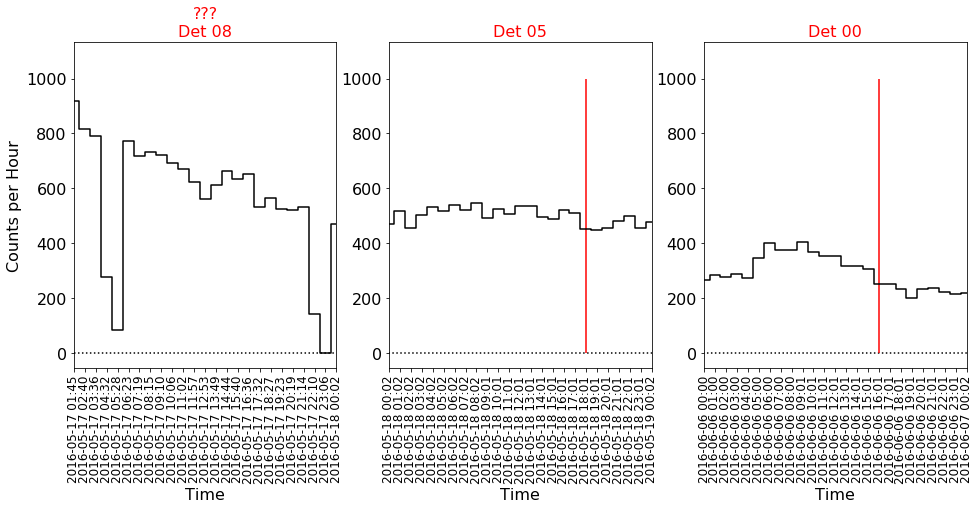

In [109]:
plt.figure(figsize=(16,6))
plt.subplot(131)
plt.step(all_times,np.sum(binned_data_GTI,axis=(2,3)).ravel(),where='mid')
plt.hlines(0,0,2e3,linestyle=':')
plt.title('???\nDet 08',color='red',fontsize=16)
plt.xticks(all_times, time_labels, rotation='vertical',fontsize=12)
plt.xlim(0*24,1*24)
plt.xlabel('Time')
plt.ylabel('Counts per Hour')
plt.subplot(132)
plt.step(all_times,np.sum(binned_data_GTI,axis=(2,3)).ravel(),where='mid')
plt.hlines(0,0,2e3,linestyle=':')
plt.title('Det 05',color='red',fontsize=16)
plt.vlines(18+24,0,1000,color='red')
plt.xticks(all_times, time_labels, rotation='vertical',fontsize=12)
plt.xlim(1*24,2*24)
plt.xlabel('Time')
plt.subplot(133)
plt.step(all_times,np.sum(binned_data_GTI,axis=(2,3)).ravel(),where='mid')
plt.hlines(0,0,2e3,linestyle=':')
plt.title('Det 00',color='red',fontsize=16)
plt.vlines(20*24+16,0,1000,color='red')
plt.xticks(all_times, time_labels, rotation='vertical',fontsize=12)
plt.xlim(20*24,21*24)
plt.xlabel('Time')

<h5>No significant change in count rate before and after detector failures at 511 keV<br>
    What about background response?</h5>

<h3>Background response plots in FISBEL dimension >> COSIpy_tools.plot_FISBEL(ll,bb_in,dll,dbb,values,colorbar=False)</h3>

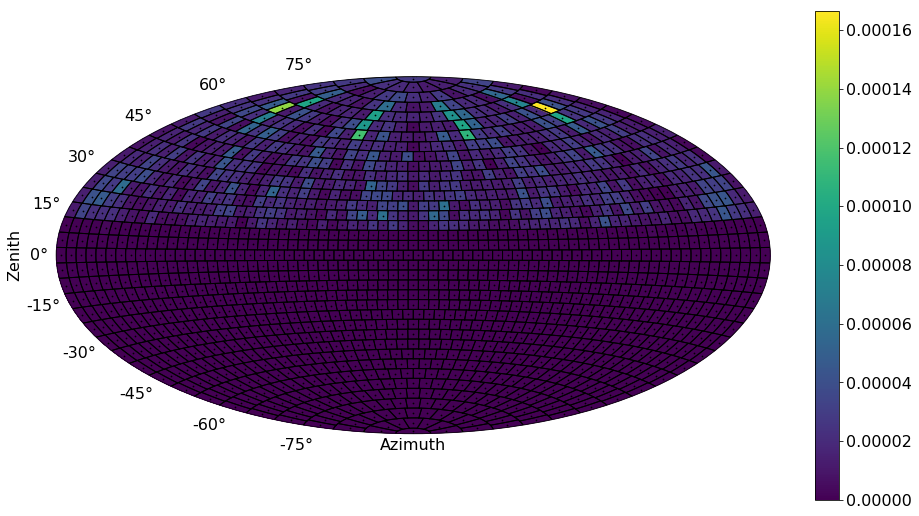

In [121]:
plot_FISBEL(ll-np.pi,bb,dll,dbb,(background_response_full.reshape(36,1650))[2,:],colorbar=True,projection='aitoff')

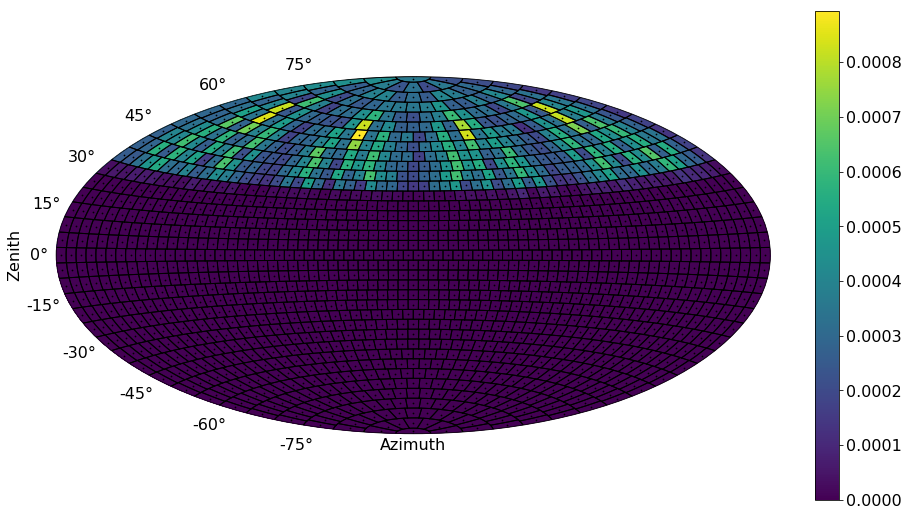

In [123]:
plot_FISBEL(ll-np.pi,bb,dll,dbb,(background_response_full.reshape(36,1650))[6,:],colorbar=True,projection='aitoff')

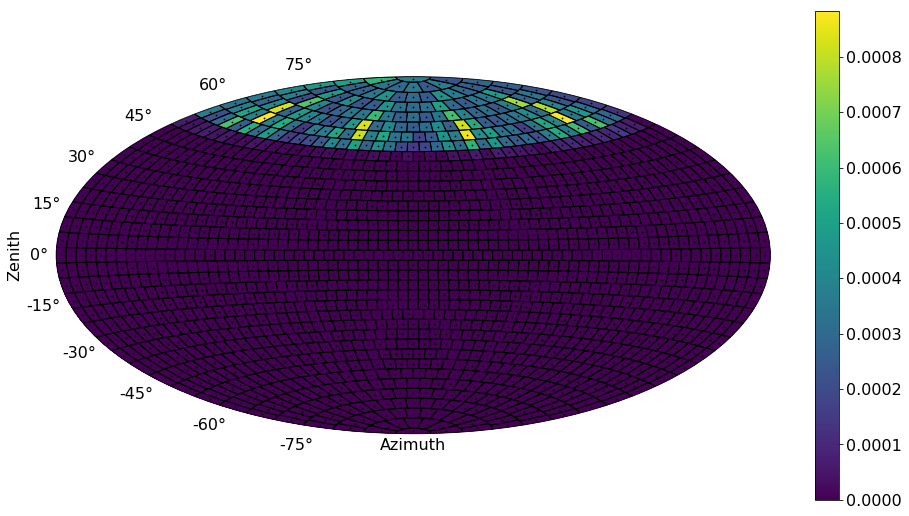

In [122]:
plot_FISBEL(ll-np.pi,bb,dll,dbb,(background_response_full.reshape(36,1650))[10,:],colorbar=True,projection='aitoff')

<h5>Structured shape with "holes" each 90 degrees apart (not completely closed shield), smoothly varying with less zenith information with increasing phi angle (2 = 12.5 deg, 6 = 32.5 deg, 10 = 52.5 deg).<br>
    As is, most of the data space is zero and we will cut out the zero entries (will not be populated at all in any case for consistent data space cuts) when we investigate the imaging response.</h5>

<h3>Because this will change in the future, I detail out the preparation of the response here:</h3>

In [125]:
import pandas as pd

In [176]:
# reading in the response file, create with MEGAlib as pandas data frame:
rsp = pd.read_csv('response/511Response_cori_v1_nuclearizer_v8_9Det_imaging_atmos_5deg_v1.binnedimaging.imagingresponse.rsp.gz',
                  skiprows=67,sep=' ',header=None,names=['MEGAlib identifier','E_in','Nu/Lambda','E_out','Phi','Psi/Chi','Sigma/Tau','Dist','Val'])
# skipped the first 67 rows by counting (even though there is information that we will need in the future)

In [177]:
rsp

,MEGAlib identifier,E_in,Nu/Lambda,E_out,Phi,Psi/Chi,Sigma/Tau,Dist,Val
0,RD,0,33,0,0,0,0,0,1
1,RD,0,213,0,0,0,0,0,1
2,RD,0,5,0,1,0,0,0,1
3,RD,0,23,0,1,0,0,0,1
4,RD,0,27,0,1,0,0,0,1
5,RD,0,36,0,1,0,0,0,1
6,RD,0,38,0,1,0,0,0,1
7,RD,0,44,0,1,0,0,0,1
8,RD,0,46,0,1,0,0,0,1
9,RD,0,55,0,1,0,0,0,1


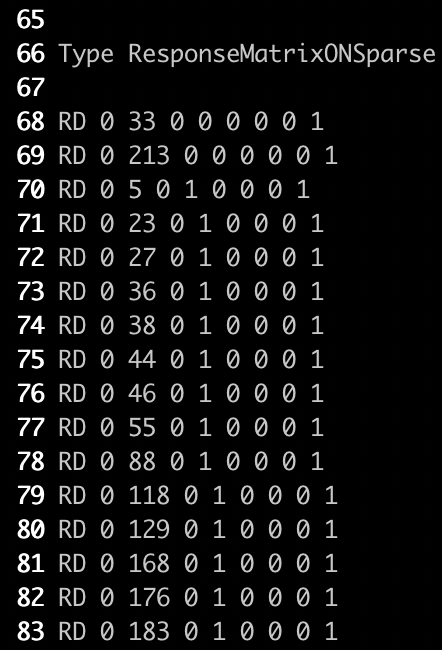

In [178]:
rsp.shape
# Note that this response matrix is sparse and defines the position of the 7 used (3 FISBEL, 1 identifier column (RD))
# to define the value in 10D (this avoids the majority of zeros)
# Screenshot of the response file (same as data frame minus header)
with open('plots/10D_SparseMatrix_excerpt.png','rb') as f:
    display(Image(data=f.read(), format='png'))

In [179]:
# define FISBELs
fisbels = FISBEL(1650,0,verbose=True)
bb = (np.array(fisbels[0]))[:,0]#-np.pi/2.
ll = (np.array(fisbels[0]))[:,1]#-np.pi
dbb = (np.array(fisbels[1]))[:,0]
dll = (np.array(fisbels[1]))[:,1]

# temporary array to choose FISBEL bins from
tmp = np.array(fisbels[0])

# define nu-lambda (sky) entries in degree
nu_lambda_indx = rsp.values[:,2].astype(int)
nu_lambda_vals = np.rad2deg(tmp[rsp.values[:,2].astype(int),:])
# define psi-chi (scatter angles) in degrees
psi_chi_indx = rsp.values[:,5].astype(int)
psi_chi_vals = np.rad2deg(tmp[rsp.values[:,5].astype(int),:])
# define phi bins in degrees
phi_indx = rsp.values[:,4].astype(int)
phi_vals = rsp.values[:,4].astype(float)*5+2.5
# get values (last column) at non-zero entries
rsp_vals = rsp.values[:,8].astype(float)
# Note that E_in (column 1), E_out (3), sigma/tau (6), and dist (7) are always 0, because we only deal with one
# energy bin and COSI cannot track electron recoils. So, still a lot of zeros there.

Number of bins: 1650
Fix bin area:  0.008
Square length:  0.087
Number of collars:   37


In [184]:
# Check some entries by hand
i = [0,12345]
nu_lambda_indx[i],phi_indx[i],psi_chi_indx[i],rsp_vals[i]

(array([ 33, 459]), array([ 0, 11]), array([0, 1]), array([  1., 102.]))

In [180]:
# define response array to fill
response = np.zeros((1650,36,1650))

In [185]:
# fill
for i in range(len(rsp_vals)):
    response[nu_lambda_indx[i],phi_indx[i],psi_chi_indx[i]] = rsp_vals[i]

Text(0.5, 0, '$\\phi x \\psi x \\chi$ DataSpace')

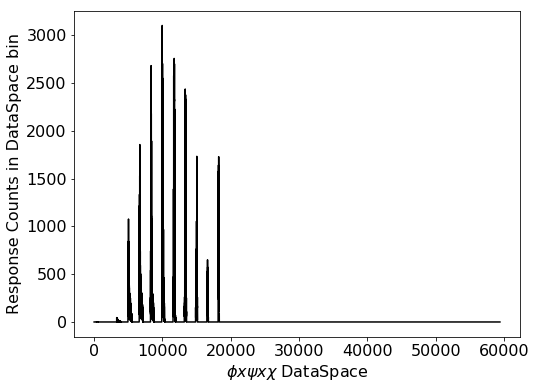

In [187]:
# 3D Compton response (not normalised!) as 1D representation:
plt.plot(response[5,:,:].ravel())
plt.ylabel('Response Counts in DataSpace bin')
plt.xlabel('$\phi x \psi x \chi$ DataSpace')

<h5> Also here, by definition of the simulation,most of the data space is actually zero. We will get rid of that after we re-gridded the response to a regular sky-grid:</h5>

In [190]:
# define regular grid of = 5 degs (not equal area any more!)
RegularBinSize = 5

l3edges = np.linspace(0,2*np.pi,np.int(360/RegularBinSize+1))
l3min = l3edges[0:-1]
l3max = l3edges[1:]
l3cen = (l3max+l3min)/2
l3wid = (l3max-l3min)

b3edges = np.linspace(0,np.pi,np.int(180/RegularBinSize+1))
b3min = b3edges[0:-1]
b3max = b3edges[1:]
b3cen = (b3max+b3min)/2
b3wid = (b3max-b3min)

L3,B3 = np.meshgrid(l3cen,b3cen)
dL3,dB3 = np.meshgrid(l3wid,b3wid)

In [191]:
# define response grid in sky dimension (for interpolation and inter-pixel finding later,
# taking source position as input for the response to fit for)
response_grid_normed = np.zeros((B3.shape[0],L3.shape[1],36,1650)) 

In [194]:
# calculate solid angle for each pixel (following MEGAlib/.../responseXX)
dll = dll.reshape(1650,)
dbb = dbb.reshape(1650,)
Omega = np.abs(np.cos(bb+dbb/2)-np.cos(bb-dbb/2))*(ll+dll/2-(ll-dll/2))
# header information from response file (copied)
start_area = 11309.7
tot_counts = 22911971589463

# re-grid data
# Note that this is not perfect as the python griddata method tries to fill the interpolated missing values
# assuming a grid already which is not the case for a sphere
# To first order, this is adequate, though, and takes some time
# I saved the response to be loaded for investigation and usage:

"""
for pi in tqdm(range(response.shape[1])):
    for pci in tqdm(range(response.shape[2])):
        tmp0 = griddata(np.array([ll,bb]).T, (response[:,pi,pci]/Omega)/(tot_counts/(4*np.pi))*start_area, (L3, B3), method='nearest')
        tmp1 = griddata(np.array([ll,bb]).T, (response[:,pi,pci]/Omega)/(tot_counts/(4*np.pi))*start_area, (L3, B3), method='cubic')
        tmp1[np.isnan(tmp1)] = tmp0[np.isnan(tmp1)]
        tmp1[np.where(tmp1 < 0)] = 0
        response_grid_normed[:,:,pi,pci] = tmp1
        
np.savez('ResponseGrid511_v3',
         response_grid_normed=response_grid_normed,
         l3cen=l3cen,
         b3cen=b3cen,
         L3=L3,
         B3=B3,
         l3wid=l3wid,
         b3wid=b3wid)
"""

# this file is ~ 1 GB in size
with np.load('response/ResponseGrid511_v3.npz',) as content:
    ResponseGrid1 = content['response_grid_normed']
    l3cen = content['l3cen']
    b3cen = content['b3cen']
    l3wid = content['l3wid']
    b3wid = content['b3wid']
    L3 = content['L3']
    B3 = content['B3']

<h3>There are several different methods to interpolate between the entries of the imaging response.<br>
    First, we perform a brute force interpolation in each data space pixel, get rid of the zeros, and then use neighbouring pixels to define the interpixel-response:</h3>

In [196]:
# we don't set a threshold as we normalised to pixel area which might be important
# rather than that, we cut beyond a certain zenith angle when the response gets fuzzy
threshold = 0.
# counting the non-zero elements
nzero = 0
nnonzero = 0

# RectBivarSpline is extremely fast when the grid is already rectangular
FullInterpolatedPSResponseBivar = []
for i in tqdm(range(ResponseGrid1.shape[2])):
    for j in range(ResponseGrid1.shape[3]):
        if (np.nansum(ResponseGrid1[:,:,i,j]) < threshold):
            FullInterpolatedPSResponseBivar.append(zero_func)
            nzero += 1
        else:
            FullInterpolatedPSResponseBivar.append(RectBivariateSpline(b3cen,l3cen,ResponseGrid1[:,:,i,j]))
            nnonzero += 1

In [198]:
len(FullInterpolatedPSResponseBivar)

59400

<h5>Now these are 59400 interpolation functions for each data space pixel (of which most of them are zero >> zero_func()) which can now take the zenith/azimuth position of a source relative to the instrument as an argument. With >> COSIpy_tools.get_response(), the response is calculated. This takes some time but might be most accurate compared to what follows below with pixel weighting.</h5>

In [199]:
zenith_response = get_response(FullInterpolatedPSResponseBivar,0,0,deg=True,cut=60)
other_response = get_response(FullInterpolatedPSResponseBivar,32.5,12.5,deg=True,cut=60)

In [207]:
# auxiliary array
arbdim = np.arange(1650*36)

(-10, 10)

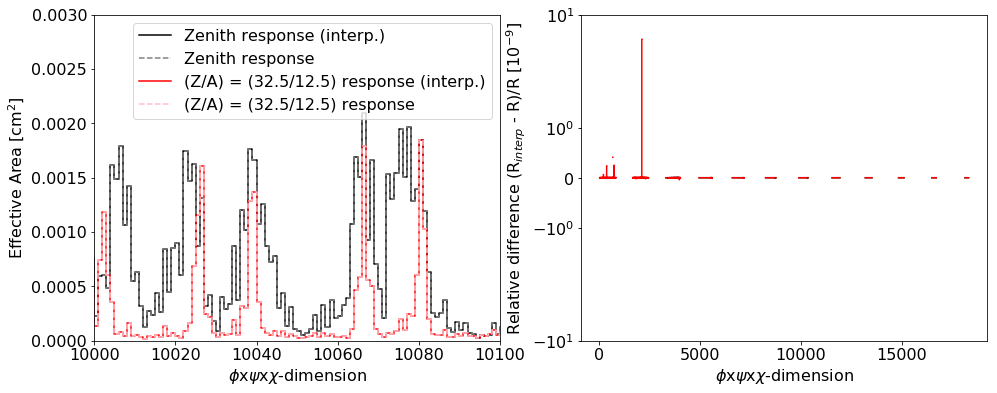

In [223]:
plt.figure(figsize=(16,6))
plt.subplot(121)

plt.step(arbdim,zenith_response,color='black',label='Zenith response (interp.)')
plt.step(arbdim,ResponseGrid1[0,0,:,:].ravel(),color='gray',label='Zenith response',linestyle='--')
plt.step(arbdim,other_response,color='red',label='(Z/A) = (32.5/12.5) response (interp.)')
plt.step(arbdim,ResponseGrid1[6,2,:,:].ravel(),color='pink',label='(Z/A) = (32.5/12.5) response',linestyle='--')
plt.xlim(10000,10100)
plt.ylim(0,0.003)
plt.xlabel('$\phi$x$\psi$x$\chi$-dimension')
plt.ylabel('Effective Area [cm$^2$]')
plt.legend()

plt.subplot(122)
plt.step(arbdim,((zenith_response-ResponseGrid1[0,0,:,:].ravel())/ResponseGrid1[0,0,:,:].ravel())*1e9,color='black')
plt.step(arbdim,((other_response-ResponseGrid1[6,2,:,:].ravel())/ResponseGrid1[6,2,:,:].ravel())*1e9,color='red')
plt.xlabel('$\phi$x$\psi$x$\chi$-dimension')
plt.ylabel('Relative difference (R$_{interp}$ - R)/R [$10^{-9}$]')
plt.yscale('symlog')
plt.ylim(-10,10)

<h3>Looks promising. Let's get rid of the zero entries by checking the "background response". If there are no entries in certain data space pixels, they will never be populated:</h3>

In [224]:
# Reshape initial response to "regular 5 deg sky" times "1D response" dimension for easy filter
NonZeroResponseGrid = ResponseGrid1.reshape(36,72,59400)
# find indices for non-zero entries
calc_this = np.where(background_response_full != 0)[0].astype(int)

# Get only these interpolation functions
NonZeroInterpolatedPSResponseBivar = []
for c in calc_this:
    NonZeroInterpolatedPSResponseBivar.append(FullInterpolatedPSResponseBivar[c])

# same for background
background_response = background_response_full[calc_this]

# and a shortened response grid
NonZeroResponseGrid = (ResponseGrid1.reshape(36,72,59400))[:,:,calc_this]

# also auxiliary variable
arbdim2 = arbdim[calc_this]

In [225]:
len(calc_this)

4587

<h5>Now we have a response which is only about 8% of the initial size and thus more than 12 times faster.</h5>

<h3>Check out effective area as a function zenith and azimuth:</h3>

In [229]:
n_zen = 18
n_azi = 72
thetag = np.linspace(0,90,n_zen+1)
theta = thetag[0:-1]+90/(n_zen*2)
phig = np.linspace(-180,180,n_azi+1)
phi = phig[0:-1]+360/(n_azi*2)
THETAg,PHIg = np.meshgrid(thetag,phig)
THETA,PHI = np.meshgrid(theta,phi)
response_area = np.zeros((n_azi,n_zen))

for t in tqdm(range(len(theta))):
    for p in range(len(phi)):
        response_area[p,t] = np.sum(get_response(NonZeroInterpolatedPSResponseBivar,theta[t],phi[p],deg=True,cut=90))

Text(0.5, 1.0, 'A$_{eff}$ averged over zeniths')

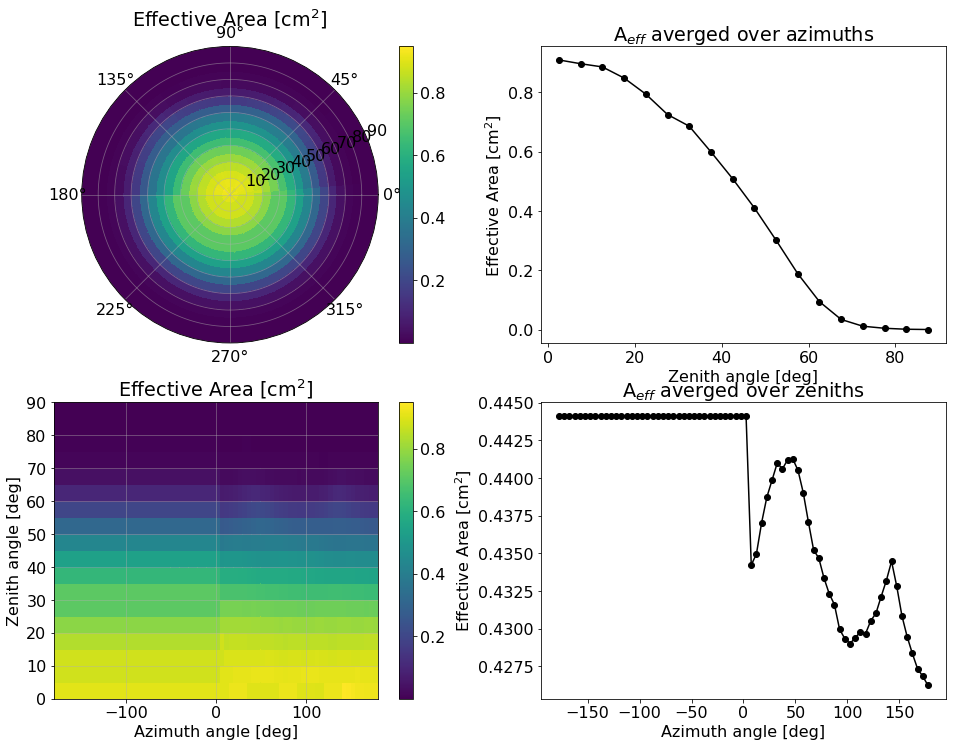

In [238]:
plt.figure(figsize=(16,12))

plt.subplot(221,projection='polar')
plt.pcolormesh(np.deg2rad(PHIg),THETAg,response_area)
plt.grid(True,alpha=0.5)
plt.colorbar()
plt.title('Effective Area [cm$^2$]')

plt.subplot(222)
plt.plot(theta,np.mean(response_area,axis=0),'o-')
plt.ylabel('Effective Area [cm$^2$]')
plt.xlabel('Zenith angle [deg]')
plt.title('A$_{eff}$ averged over azimuths')

plt.subplot(223)
plt.pcolormesh(PHIg,THETAg,response_area)
plt.grid(True,alpha=0.5)
plt.colorbar()
plt.xlabel('Azimuth angle [deg]')
plt.ylabel('Zenith angle [deg]')
plt.title('Effective Area [cm$^2$]')

plt.subplot(224)
plt.plot(phi,np.mean(response_area,axis=1),'o-')
plt.ylabel('Effective Area [cm$^2$]')
plt.xlabel('Azimuth angle [deg]')
plt.title('A$_{eff}$ averged over zeniths')

<h3>Smooth behaviour in Zenith, dropping reapidly towards the edge of the FoV. Azimuths show few % variation, probably due to the initial interpolation (mainly changing the zenith response area)</h3>

<h5>Still, the response calculation for only 1296 zenith/aizmuth pairs is too slow to be useful. In the following, I will introduce several pixel weighting methods to get the response.</h3>

<h3>Get response from pixel weights >> COSIpy_tools.get_response_with_weights() and related functions:</h3>

<h3>In order to have some realistic observation pattern, we use the orientation file from Day 42 of the flight and a certain hour. We further assume that in this time a nova flash happaned with a flux of 1e-2 ph/cm2/s at 511 keV which would be expected for a classical nova closer than ~500 pc.<br>
    With this example, I also show what is going on with the fitted flux when directly using the MEGAlib simulation output if the atmosphere is not taken into account></h3>

In [253]:
# read in data set
dir = 'datasets/9det_nova/'
COSI_Data_sim_nova9 = read_COSI_DataSet(dir)

In [254]:
# get time indices and binning to appropriate data space
tdx_sim_nova9 = np.array(hourly_tags(COSI_Data_sim_nova9))
tdx_sim_nova9 = tdx_sim_nova9.reshape(1,24)
sim_data_nova9 = hourly_binning(COSI_Data_sim_nova9)
binned_data_sim_nova9 = get_binned_data_complete(COSI_Data_sim_nova9,pp,bb,ll,dpp,dbb,dll)

In [255]:
len(COSI_Data_sim_nova9[0]['TimeTags'])

97

<h5>We have 97 photons in our input data set

In [322]:
# expected flux
flux = 1e-2
# observation time
Tobs = 3600
# simulated source position
sim_source = -1.23, -4.50

# coordinates / orientation of COSI at each instance of time (pointing)
zs = np.rad2deg(COSI_Data_sim_nova9[0]['Zpointings'])
xs = np.rad2deg(COSI_Data_sim_nova9[0]['Xpointings'])
ys = np.rad2deg(COSI_Data_sim_nova9[0]['Ypointings'])

# calculate zeniths and azimuths for all pointings, given the source position
zens,azis = zenazi(xs[:,0],xs[:,1],
                   ys[:,0],ys[:,1],
                   zs[:,0],zs[:,1],
                   sim_source[0],sim_source[1])

# calculate mean response over time
nova_response_full = np.mean(get_response_with_weights(ResponseGrid1.reshape(36,72,59400),zens,azis,cut=60),axis=0)

In [330]:
# estimate counts
np.sum(nova_response_full)*flux*Tobs

31.221952776665308

<h5>Got 97, expect 31, so the simulation probably doesn't include the atmosphere (plus maybe some additional missing information)</h5>

<h3>Let's get some information out of that data set:</h3>

Time edges if significant change in rate:  [1.46709084e+09 1.46709436e+09]


(0, 10)

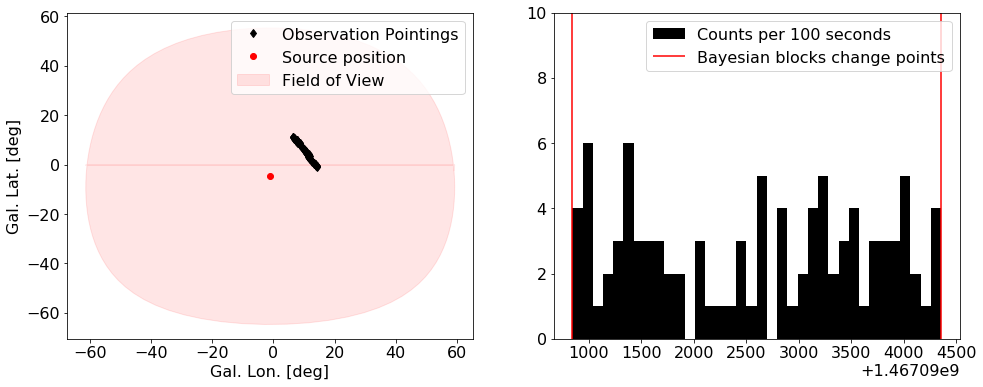

In [324]:
fig, (ax1, ax2) = plt.subplots(nrows=1,ncols=2,figsize=(16,6))
ax1.plot(zs[:,0],zs[:,1],'d',label='Observation Pointings')
ax1.plot(sim_source[0],sim_source[1],'ro',label='Source position')
circ = circle_on_the_sky(sim_source[0],sim_source[1],60) # calculate circle of FoV
ax1.fill_between(circ[0],circ[1],color='red',alpha=0.1,label='Field of View')
ax1.set_xlabel('Gal. Lon. [deg]')
ax1.set_ylabel('Gal. Lat. [deg]')
ax1.legend()

edges = bayesian_blocks(COSI_Data_sim_nova9[0]['TimeTags'],fitness='events',p0=1-0.9973)
print('Time edges if significant change in rate: ',edges)
ax2.hist(COSI_Data_sim_nova9[0]['TimeTags'],bins=36,label='Counts per 100 seconds')
ax2.vlines(edges,0,75,colors='red',label='Bayesian blocks change points')
ax2.legend()
ax2.set_ylim(0,10)

<h5>Everything nice and smooth</h5>

<h3>Let's draw samples from a "SOURCE ONLY" data set according to the response of a point source at the position of the simulated source, given the flux and observation time.</br>
Then, we fit that, searching for the point source position, the flux, and take into account a background model that we defined before:</h3>

In [329]:
fake_data1 = np.random.poisson(nova_response_full*flux*Tobs)

<h5>Done.</h5>

<h3>Define fitting model:<br>
Here, we use emcee to fit for position, background, and flux:</h3>


In [374]:
# Fitting model:
# define response calculation threshold globally
cut = 60

# Calculate prior
def lnprior_PSsearchFlux(theta,zs):
    """
    Return log-prior probability of a parameter set theta,
    setting normal, weakly informative, priors on the flux
    and background scaling, plus a uniform circular region
    inside the field of view, and normal priors on the
    position (also weakly informative)
    :param: theta     Array of fitted parameters with
                      theta[0] = F_sky (sky flux)
                      theta[1] = A_bg (BG scaling)
                      theta[2] = Gal. Lon. of source (deg)
                      theta[3] = Gal. Lat. of source (deg)
    :param: zs        Array of pointing directions to calculate
                      threshold for outside field of view
    
    """
    # define fit parameters
    F_sky,A_bg,l,b = theta
    # normal prior on flux (typically 1e-6..1e-1)
    mu_F_sky = 0
    sigma_F_sky = 10
    # normal prior on BG
    mu_A_bg = 0
    sigma_A_bg = 10000

    # calculate minimum and maximum observation (and mean)
    lzm = minmax(zs[:,0])
    bzm = minmax(zs[:,1])
    mean_zl = np.mean(zs[:,0])
    mean_zb = np.mean(zs[:,1])
    
    # normal prior on source position (mean of observation) as centre
    mu_l = mean_zl
    sigma_l = 20 # within 3 sigma, (= 60 deg), everything can be captured
    mu_b = mean_zb
    sigma_b = 20
    
    # get distance to outermost observations
    dist = angular_distance(lzm,bzm,l,b,deg=True)
    
    """if l > 180:
        l -= 360
    if l <= -180:
        l += 360"""
    
    # if distance of source is larger than 60 deg to outermost points, return -infinity
    # also check for inside "one sky"
    if ((dist[1] < cut) & (dist[0] < cut)) & (-90 <= b <= 90) & (-180 < l <= 180):
        return -0.5*(F_sky-mu_F_sky)**2/sigma_F_sky**2 -0.5*(A_bg-mu_A_bg)**2/sigma_A_bg**2 -0.5*(l-mu_l)**2/sigma_l**2 -0.5*(b-mu_b)**2/sigma_b**2
    return -np.inf
    
# Calculate likelihood
def lnlike_PSsearchFlux(theta, data, response_sky, xs, ys, zs, response_bg, Texp, area_flag):
    """
    Return the Poisson log-likelihood of the fitting model
    with parameters theta, given the data. Using instrument
    orientation, to calculate sky response on the fly and
    background model response to fit for flux, BG, l, b.
    :param: theta           Array of fitted parameters with
                            theta[0] = F_sky (sky flux)
                            theta[1] = A_bg (BG scaling)
                            theta[2] = Gal. Lon. of source (deg)
                            theta[3] = Gal. Lat. of source (deg)
    :param: response_sky    Response grid with regular sky dimension
    :param: xs              Array of pointing x-directions
    :param: ys              Array of pointing y-direction
    :param: zs              Array of pointing directions to calculate
                            threshold for outside field of view
    :param: response_bg     Background response, valid for all times
    :param: Texp            Exposure/observation time in seconds
    :param: area_flag       Option to calculate response by area
                            (which is buggy) instead of by distance
    """
    # define fit parameters
    F_sky,A_bg,l,b = theta
    
    # define zeniths and azimuths for given source position l/b
    zens,azis = zenazi(xs[:,0],xs[:,1],
                       ys[:,0],ys[:,1],
                       zs[:,0],zs[:,1],
                       l,b)
    
    # check which response calculation should be used
    if area_flag == True:
        sky_response = np.mean(get_response_with_weights_area(response_sky,zens,azis,cut=cut),axis=0)
    else:
        sky_response = np.mean(get_response_with_weights(response_sky,zens,azis,cut=cut),axis=0)
    
    # calculate sky model count expectaion
    model_sky = F_sky*Texp*sky_response
    # calculate BG model count expectation
    model_bg = A_bg*response_bg
    # add together
    model_tot = model_sky + model_bg

    # check for any negative model counts to return -infinity (zero counts model predictions are allowed)
    if np.any(model_tot < 0):
        return -np.inf
    else:
        # calculate Poisson likelihood
        stat = -2*np.sum(model_tot - data*np.nan_to_num(np.log(model_tot)))
        return stat

# Calculate posterior
def lnprob_PSsearchFlux(theta, data, response_sky, xs, ys, zs, response_bg,Texp,area_flag):
    """
    Return the log-posterior of the fitting model using above-
    defined likelihood and prior.
    :param: theta           Array of fitted parameters with
                            theta[0] = F_sky (sky flux)
                            theta[1] = A_bg (BG scaling)
                            theta[2] = Gal. Lon. of source (deg)
                            theta[3] = Gal. Lat. of source (deg)
    :param: response_sky    Response grid with regular sky dimension
    :param: xs              Array of pointing x-directions
    :param: ys              Array of pointing y-direction
    :param: zs              Array of pointing directions to calculate
                            threshold for outside field of view
    :param: response_bg     Background response, valid for all times
    :param: Texp            Exposure/observation time in seconds
    :param: area_flag       Option to calculate response by area
                            (which is buggy) instead of by distance
    """
    # get prior
    lp = lnprior_PSsearchFlux(theta,zs)
    if not np.isfinite(lp):
        return -np.inf
    # add prior to likelihood and return posterior
    return lp + lnlike_PSsearchFlux(theta, data, response_sky, xs, ys, zs, response_bg,Texp,area_flag)

<h3>Set up a fit:</h3>

In [375]:
# only use the non-zero entries
tmp_data = fake_data1[calc_this]
# cross-check number of photons simulated
print(np.sum(tmp_data))

# set 4 dimensions, one for each fit parameters
# 20 walkers >> 4 dimensions
ndim, nwalkers = 4, 20
# initial guess, here close to the true values
guess = np.array([flux,10, sim_source[0], sim_source[1]])
# add random points around that guess for each walker differently
pos = guess[:, None] + np.random.randn(ndim,nwalkers)*np.repeat([1e-4,1,1,1],nwalkers).reshape(ndim,nwalkers)
pos = pos.T

# make sure we use the correct observation again
zs = np.rad2deg(COSI_Data_sim_nova9[0]['Zpointings'])
xs = np.rad2deg(COSI_Data_sim_nova9[0]['Xpointings'])
ys = np.rad2deg(COSI_Data_sim_nova9[0]['Ypointings'])

# set up sampler
sampler = emcee.EnsembleSampler(nwalkers,
                                ndim,
                                lnprob_PSsearchFlux,
                                args=(tmp_data,
                                      NonZeroResponseGrid,
                                      xs,ys,zs,
                                      background_response,
                                      Tobs,False)) # set up sampler
# sample
_ = sampler.run_mcmc(pos, 300, progress=True) # sample

33


100%|██████████| 300/300 [01:30<00:00,  3.45it/s]


<h5>With 90 seconds, this is still very slow. Don't know how to speed this one :(</h5>

<h3>Check the fit:</h3>

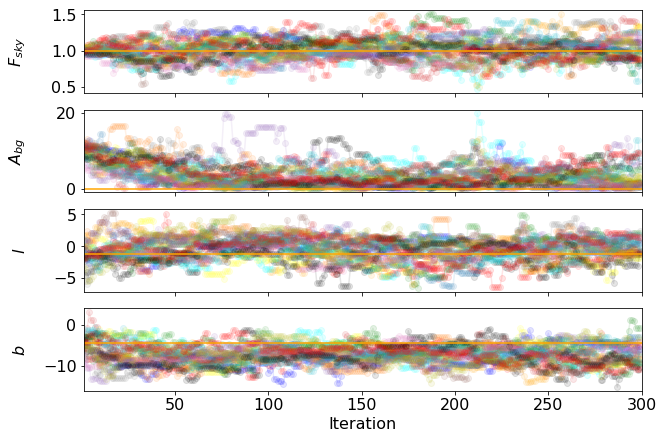

In [381]:
scl = [1e2,1,1,1]
fig, axes = plt.subplots(ndim, figsize=(ndim*2.5, 7), sharex=True)
samplesg = sampler.get_chain()*scl
labels = ["$F_{sky}$", "$A_{bg}$", "$l$", "$b$"]
truths = np.array([flux,0,sim_source[0],sim_source[1]])*scl
for i in range(4):
    ax = axes[i]
    ax.plot(np.arange(len(samplesg)),samplesg[:, :, i], alpha=0.1,marker='o')
    ax.set_xlim(1, len(samplesg))
    ax.plot([1,len(samplesg)],[truths[i],truths[i]],color='orange')
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)
    #ax.set_xscale('log')

axes[-1].set_xlabel("Iteration");

<h5>Looks mixed enough</h5>

Text(0, 0.5, 'Log(Posterior probability)')

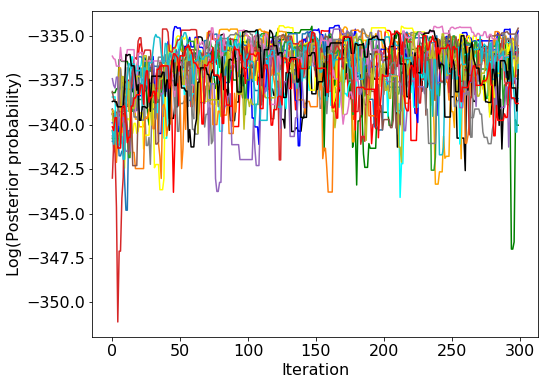

In [382]:
samplesf = sampler.flatchain
samplesf.shape
plt.plot(sampler.lnprobability)
plt.xlabel('Iteration')
plt.ylabel('Log(Posterior probability)')

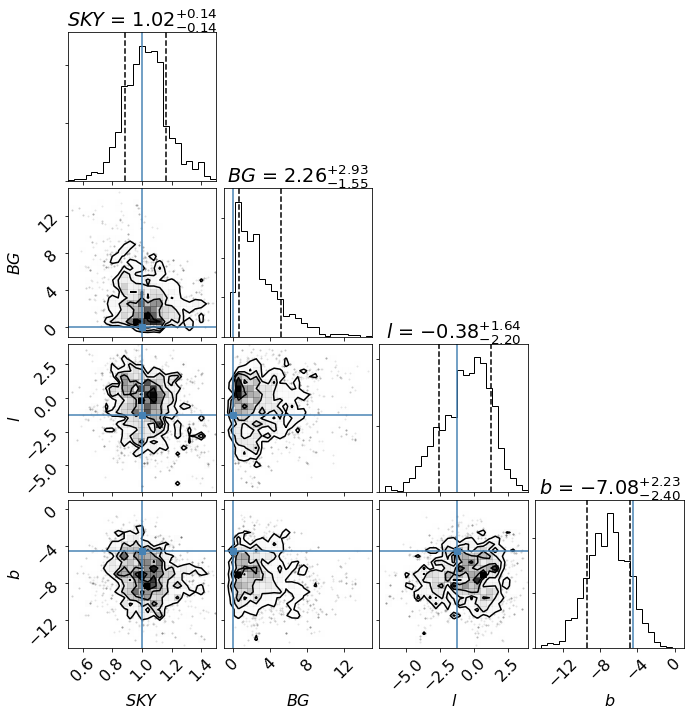

In [390]:
tmp = corner.corner(samplesf[100*nwalkers:,:]*scl, labels=["$SKY$","$BG$", "$l$", "$b$"],
                    truths=truths,
                    quantiles=[0.5-0.683/2,0.5+0.683/2],show_titles=True,
                    range=[(0.5,1.5),(-1,15),(-7,4),(-15,1)],
                    bins=25)
tmp.set_size_inches(10,10)

<h3>Basically nailed it: Found the flux (1e-2), found no BG (0), and l and b arehit within ~1 sigma.<br>With ~30 photons.<br>Of course without background, but with the instrument moving!</br>
Now with background:</h3>

In [391]:
Abg = 100
fake_data2 = np.random.poisson(nova_response_full*flux*Tobs + Abg*background_response_full)

In [392]:
# only use the non-zero entries
tmp_data = fake_data2[calc_this]
# cross-check number of photons simulated
print(np.sum(tmp_data))

# set 4 dimensions, one for each fit parameters
# 20 walkers >> 4 dimensions
ndim, nwalkers = 4, 20
# initial guess, here close to the true values
guess = np.array([flux,10, sim_source[0], sim_source[1]])
# add random points around that guess for each walker differently
pos = guess[:, None] + np.random.randn(ndim,nwalkers)*np.repeat([1e-4,1,1,1],nwalkers).reshape(ndim,nwalkers)
pos = pos.T

# make sure we use the correct observation again
zs = np.rad2deg(COSI_Data_sim_nova9[0]['Zpointings'])
xs = np.rad2deg(COSI_Data_sim_nova9[0]['Xpointings'])
ys = np.rad2deg(COSI_Data_sim_nova9[0]['Ypointings'])

# set up sampler
sampler2 = emcee.EnsembleSampler(nwalkers,
                                ndim,
                                lnprob_PSsearchFlux,
                                args=(tmp_data,
                                      NonZeroResponseGrid,
                                      xs,ys,zs,
                                      background_response,
                                      Tobs,False)) # set up sampler
# sample
_ = sampler2.run_mcmc(pos, 300, progress=True) # sample

137


100%|██████████| 300/300 [01:28<00:00,  3.61it/s]


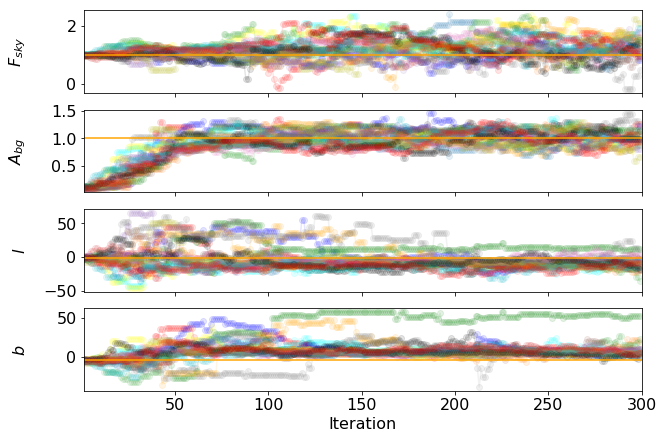

In [393]:
scl = [1e2,1e-2,1,1]
fig, axes = plt.subplots(ndim, figsize=(ndim*2.5, 7), sharex=True)
samplesg2 = sampler2.get_chain()*scl
labels = ["$F_{sky}$", "$A_{bg}$", "$l$", "$b$"]
truths = np.array([flux,Abg,sim_source[0],sim_source[1]])*scl
for i in range(4):
    ax = axes[i]
    ax.plot(np.arange(len(samplesg2)),samplesg2[:, :, i], alpha=0.1,marker='o')
    ax.set_xlim(1, len(samplesg2))
    ax.plot([1,len(samplesg2)],[truths[i],truths[i]],color='orange')
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)
    #ax.set_xscale('log')

axes[-1].set_xlabel("Iteration");

Text(0, 0.5, 'Log(Posterior probability)')

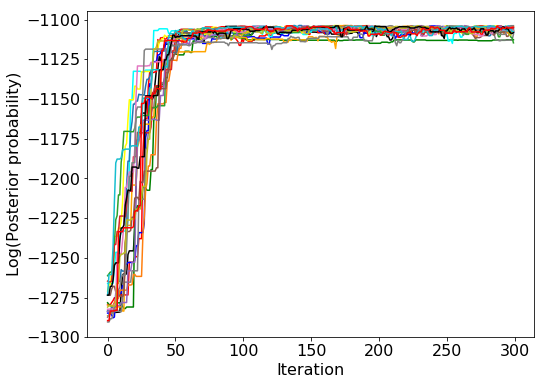

In [394]:
samplesf2 = sampler2.flatchain
samplesf2.shape
plt.plot(sampler2.lnprobability)
plt.xlabel('Iteration')
plt.ylabel('Log(Posterior probability)')

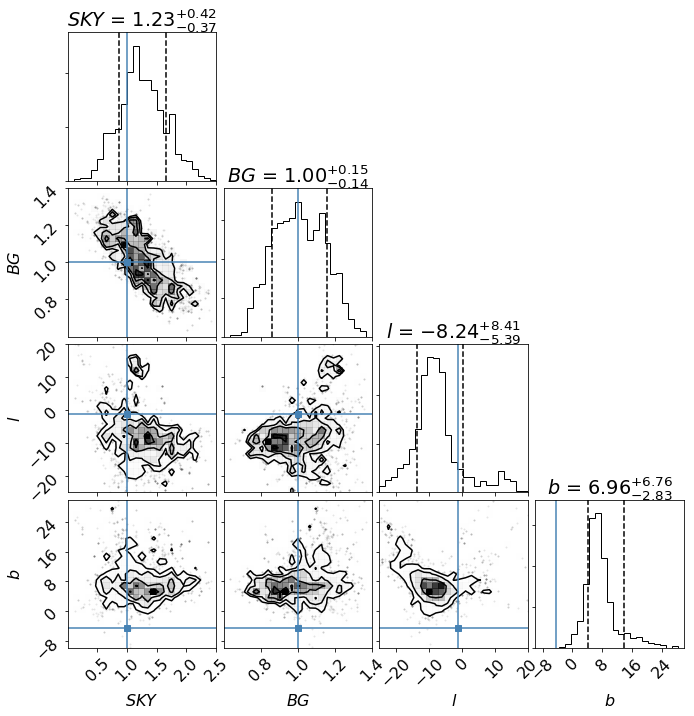

In [397]:
tmp = corner.corner(samplesf2[100*nwalkers:,:]*scl, labels=["$SKY$","$BG$", "$l$", "$b$"],
                    truths=truths,
                    quantiles=[0.5-0.683/2,0.5+0.683/2],show_titles=True,
                    range=[(0.0,2.5),(0.6,1.4),(-25,20),(-10,30)],
                    bins=25)
tmp.set_size_inches(10,10)

<h3>As expected from a ~3 sigma source, we see it, but due to background variations, we see it shifted compared to where we expected it.<br>Now, we fit the source as simulated with MEGAlib:</h3>

In [404]:
# only use the non-zero entries
tmp_data = binned_data_sim_nova9.ravel()[calc_this]
# cross-check number of photons simulated
print(np.sum(tmp_data))

# set 4 dimensions, one for each fit parameters
# 20 walkers >> 4 dimensions
ndim, nwalkers = 4, 20
# initial guess, here, let's start from a wrong position to check the algorithm
guess = np.array([flux,10, 30, -40])
# add random points around that guess for each walker differently
pos = guess[:, None] + np.random.randn(ndim,nwalkers)*np.repeat([1e-4,1,1,1],nwalkers).reshape(ndim,nwalkers)
pos = pos.T

# make sure we use the correct observation again
zs = np.rad2deg(COSI_Data_sim_nova9[0]['Zpointings'])
xs = np.rad2deg(COSI_Data_sim_nova9[0]['Xpointings'])
ys = np.rad2deg(COSI_Data_sim_nova9[0]['Ypointings'])

# set up sampler
sampler3 = emcee.EnsembleSampler(nwalkers,
                                ndim,
                                lnprob_PSsearchFlux,
                                args=(tmp_data,
                                      NonZeroResponseGrid,
                                      xs,ys,zs,
                                      background_response,
                                      Tobs,False)) # set up sampler
# sample, now 2000 iterations to have more time for convergence
_ = sampler3.run_mcmc(pos, 2000, progress=True) # sample

97.0


100%|██████████| 2000/2000 [08:55<00:00,  3.76it/s]


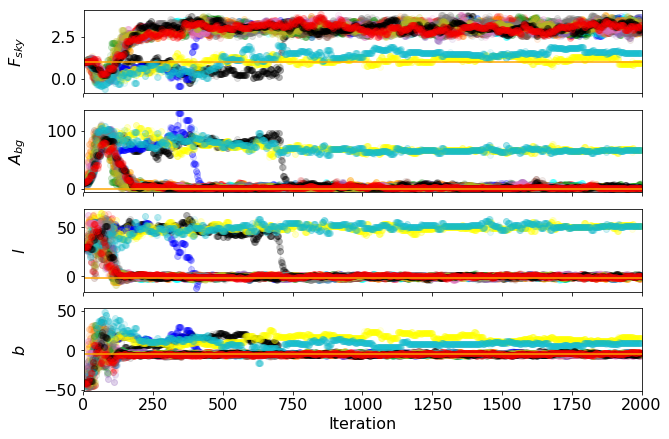

In [412]:
scl = [1e2,1,1,1]
fig, axes = plt.subplots(ndim, figsize=(ndim*2.5, 7), sharex=True)
samplesg3 = sampler3.get_chain()*scl
labels = ["$F_{sky}$", "$A_{bg}$", "$l$", "$b$"]
truths = np.array([flux,0,sim_source[0],sim_source[1]])*scl
for i in range(ndim):
    ax = axes[i]
    ax.plot(np.arange(len(samplesg3)),samplesg3[:, :, i], alpha=0.1,marker='o')
    ax.set_xlim(1, len(samplesg3))
    ax.plot([1,len(samplesg3)],[truths[i],truths[i]],color='orange')
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)
    #ax.set_xscale('log')

axes[-1].set_xlabel("Iteration");

Text(0, 0.5, 'Log(Posterior probability)')

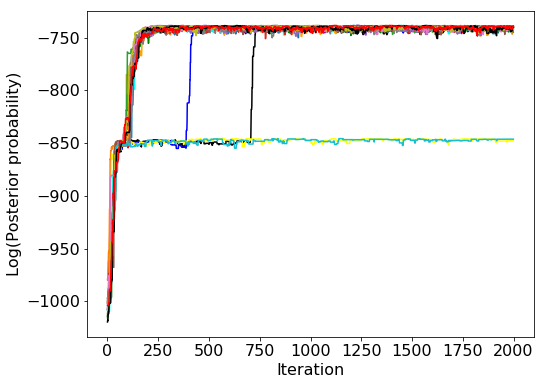

In [413]:
samplesf3 = sampler3.flatchain
samplesf3.shape
plt.plot(sampler3.lnprobability)
plt.xlabel('Iteration')
plt.ylabel('Log(Posterior probability)')

<h5>Apparently two chains did not converge to the others, skip them for the moment</h5>

In [429]:
good_chains = np.where(np.median(sampler3.lnprobability,axis=0) > -800)[0]

In [436]:
samplesf3n = sampler3.get_chain()[:,good_chains,:].reshape(2000*len(good_chains),ndim)

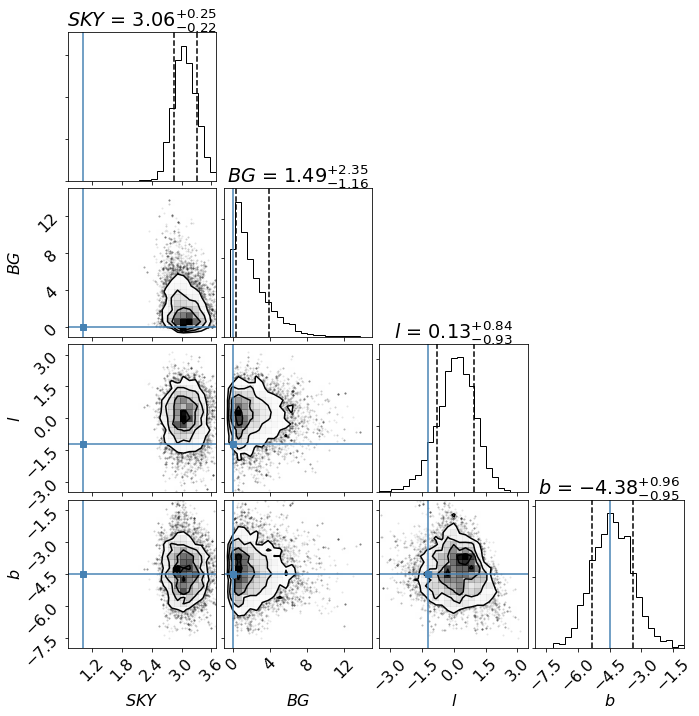

In [438]:
tmp = corner.corner(samplesf3n[1000*nwalkers:,]*scl, labels=["$SKY$","$BG$", "$l$", "$b$"],
                    truths=truths,
                    quantiles=[0.5-0.683/2,0.5+0.683/2],show_titles=True,
                    range=[(0.7,3.7),(-1,15),(-3.5,3.5),(-8,-1)],
                    bins=25)
tmp.set_size_inches(10,10)

<h3>Basically beautifully recover the position and the background, if there wasn't the thing with the flux being 3 times larger than what we put in MEGAlib.<br><br>
    This is due to the fact that the response takes the atmosphere into account but the simulation I did not. (strong effect of zenith angle, and if instrument is moving, even loss of signal because everything is skewed!)<br>This has to be understood first before further things are implemented.</h3>